In [37]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
import torch
import pandas as pd

torch.manual_seed(0)


class ReviewPuskesmasDataset(Dataset):
    def __init__(self, pandas_df, maxlen, labeled=True):
        self.df = pandas_df.reset_index(drop=True)
        self.classes = [0, 1]
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.maxlen = maxlen
        self.labeled = labeled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence = self.df.loc[index, "cleaned_review_text"]
        input_ids = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            max_length=self.maxlen,
        )["input_ids"][0]
        attention_mask = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            max_length=self.maxlen,
        )["attention_mask"][0]

        if self.labeled:
            label = torch.tensor(
                self.classes.index(self.df.loc[index, "is_positive"]), dtype=torch.long
            )
            return {
                "sentence": sentence,
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "label": label,
            }
        else:
            return {
                "sentence": sentence,
                "input_ids": input_ids,
                "attention_mask": attention_mask,
            }

In [38]:
from torch import nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attn(lstm_output)
        attention_scores = attention_scores.squeeze(2)

        return F.softmax(attention_scores, dim=1)

In [39]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class SentimentClassifier(nn.Module):
    def __init__(
        self,
        tokenizer,
        embedding_dim=128,
        hidden_dim=256,
        output_dim=2,
        n_layers=2,
        bidirectional=True,
        dropout=0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(len(tokenizer.get_vocab()), embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True,
        )

        self.attention = Attention(hidden_dim * 2 if bidirectional else hidden_dim)

        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
        )
        _, (hidden, _) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        dense_outputs = self.fc(hidden)
        outputs = self.act(dense_outputs)
        return outputs.squeeze()

In [40]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np


class EarlyStopping:
    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_epoch = 0  # Add this line

    def __call__(self, val_loss, epoch, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            self.best_epoch = epoch  # Update the best epoch

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Data Load

In [41]:
import pandas as pd

data_puskesmas = pd.read_csv("preprocessed-review.csv")
data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id
3,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id
4,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id


In [42]:
train_data = data_puskesmas[
    (data_puskesmas["rating"] == 5) | (data_puskesmas["rating"] == 1)
]
test_data = data_puskesmas[
    (data_puskesmas["rating"] != 5) & (data_puskesmas["rating"] != 1)
]

print("train_data.shape:", train_data.shape)
print("test_data.shape:", test_data.shape)

train_data.shape: (7808, 6)
test_data.shape: (1218, 6)


test data adalah data yang tidak jelas dia tergolong positif atau negatif, sehingga kita perlu melakukan prediksi terhadap data tersebut. Karena data tersebut berkisar antara rating 1-5, maka kita akan menggunakan model klasifikasi untuk memprediksi data tersebut.

In [43]:
# make the rating 5 as 1 and the rating 1 as 0
train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)

print(train_data["is_positive"].value_counts())

is_positive
1    4953
0    2855
Name: count, dtype: int64


/tmp/ipykernel_46495/3329991187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['is_positive'] = train_data['rating'].apply(lambda x: 1 if x == 5 else 0)


In [44]:
from sklearn.model_selection import train_test_split

train_data_resample, val_data = train_test_split(
    train_data, test_size=0.2, random_state=42, stratify=train_data["is_positive"]
)

print("train_data_resample.shape:", train_data_resample.shape)
print("val_data.shape:", val_data.shape)

train_data_resample.shape: (6246, 7)
val_data.shape: (1562, 7)


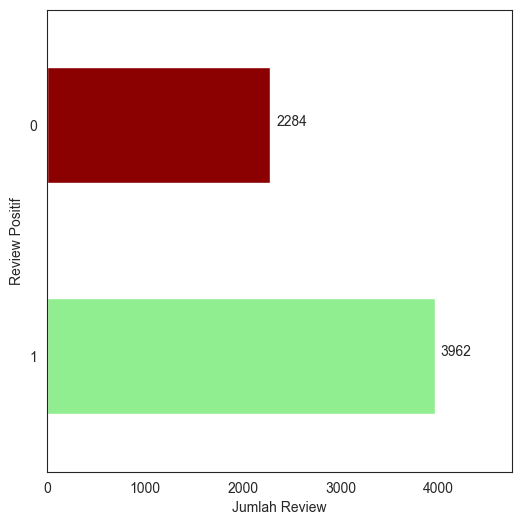

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

In [46]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(
    train_data_resample, train_data_resample["is_positive"]
)

train_data_resample = pd.DataFrame(X_resampled, columns=train_data.columns)

print(train_data_resample["is_positive"].value_counts())

is_positive
0    2284
1    2284
Name: count, dtype: int64


nanti datanya akan dicombine ulang untuk analsis lebih lanjut

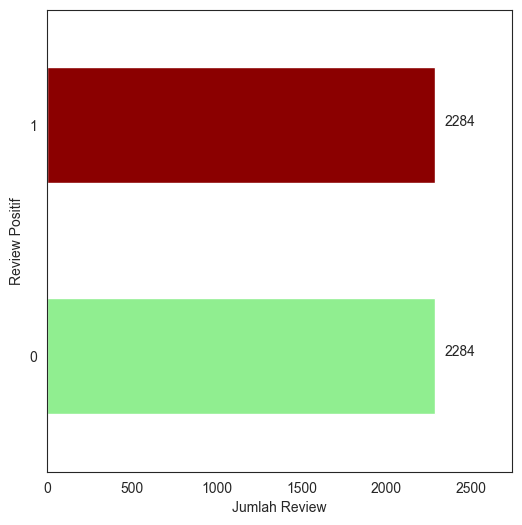

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

In [48]:
train_set = ReviewPuskesmasDataset(train_data_resample, maxlen=512)
val_set = ReviewPuskesmasDataset(val_data, maxlen=512)

In [49]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, num_workers=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, num_workers=5)

In [50]:
model = SentimentClassifier(
    train_set.tokenizer,
    embedding_dim=64,
    hidden_dim=128,
    output_dim=2,
    n_layers=3,
    bidirectional=True,
    dropout=0.8,
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=10)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [52]:
model = model.to(device)
criterion = criterion.to(device)

In [53]:
print(model)

SentimentClassifier(
  (embedding): Embedding(30522, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.8, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (act): Sigmoid()
)


In [54]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
import torch
from tqdm.notebook import tqdm
from IPython.display import clear_output

NUM_EPOCHS = 100
CLIP = 1.0
torch.manual_seed(0)

scheduler = ReduceLROnPlateau(optimizer, "min", min_lr=1e-10)

metrics_df = pd.DataFrame(
    columns=[
        "Epoch",
        "Training Loss",
        "Training Accuracy",
        "Validation Loss",
        "Validation Accuracy",
        "Roc Auc",
        "Precision",
        "Recall",
        "F1",
    ]
)


def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    losses = []
    correct_preds = 0
    total_samples = 0
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        text_lengths = (input_ids != 0).sum(dim=1).cpu()

        optimizer.zero_grad(set_to_none=True)
        outputs = model(input_ids, text_lengths)

        _, preds = torch.max(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

    accuracy = correct_preds / total_samples
    return sum(losses) / len(losses), accuracy


def evaluate_epoch(model, test_loader, criterion, device):
    model.eval()
    correct_preds = []
    all_labels = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluation batches"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            text_lengths = (input_ids != 0).sum(dim=1).cpu()

            outputs = model(input_ids, text_lengths)

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            correct_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, correct_preds, sum(losses) / len(losses)


def calculate_metrics(all_labels, correct_preds):
    accuracy = accuracy_score(all_labels, correct_preds)
    roc_auc = roc_auc_score(all_labels, correct_preds)
    precision = precision_score(all_labels, correct_preds)
    recall = recall_score(all_labels, correct_preds)
    f1 = f1_score(all_labels, correct_preds)

    return accuracy, roc_auc, precision, recall, f1


for epoch in tqdm(range(NUM_EPOCHS), desc="Training progress"):
    epoch_loss, training_accuracy = train_epoch(
        model, train_loader, optimizer, criterion, device
    )

    all_labels, correct_preds, validation_loss = evaluate_epoch(
        model, val_loader, criterion, device
    )

    scheduler.step(validation_loss)

    accuracy, roc_auc, precision, recall, f1 = calculate_metrics(
        all_labels, correct_preds
    )

    metrics_df = pd.concat(
        [
            metrics_df,
            pd.DataFrame(
                [
                    {
                        "Epoch": epoch,
                        "Training Loss": epoch_loss,
                        "Training Accuracy": training_accuracy,
                        "Validation Loss": validation_loss,
                        "Validation Accuracy": accuracy,
                        "Roc Auc": roc_auc,
                        "Precision": precision,
                        "Recall": recall,
                        "F1": f1,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

    clear_output(wait=True)
    display(metrics_df)

    early_stopping(validation_loss, epoch, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

metrics_df = metrics_df[metrics_df["Epoch"] <= early_stopping.best_epoch]
metrics_df["Epoch"] += 1

model.load_state_dict(torch.load("checkpoint.pt"))

,Epoch,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy,Roc Auc,Precision,Recall,F1
0,0,0.576307,0.720228,0.501110,0.809859,0.765908,0.802265,0.929364,0.861150
1,1,0.518578,0.790061,0.469442,0.843150,0.822576,0.860039,0.899092,0.879132
2,2,0.492208,0.817207,0.484528,0.827785,0.803416,0.843810,0.894046,0.868202
3,3,0.476185,0.835158,0.464245,0.848271,0.834034,0.875498,0.886983,0.881203
4,4,0.466828,0.846760,0.525131,0.784891,0.813774,0.939597,0.706357,0.806452
5,5,0.479364,0.829028,0.561597,0.749040,0.793313,0.962906,0.628658,0.760684
6,6,0.478442,0.832093,0.463064,0.849552,0.864362,0.945755,0.809284,0.872213
7,7,0.436434,0.875438,0.470928,0.840589,0.804600,0.831843,0.938446,0.881935
8,8,0.448093,0.862960,0.441158,0.870038,0.864549,0.907867,0.884965,0.896270
9,9,0.426552,0.887478,0.482057,0.828425,0.852536,0.958175,0.762866,0.849438


EarlyStopping counter: 10 out of 10
Early stopping


<All keys matched successfully>

In [55]:
torch.cuda.empty_cache()

import gc

gc.collect()

9145

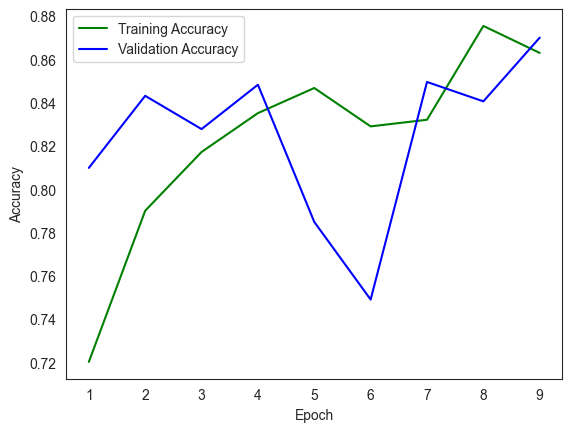

In [56]:
# plot the training accuracy vs validation accuracy
import matplotlib.pyplot as plt

plt.plot(
    metrics_df["Epoch"],
    metrics_df["Training Accuracy"],
    label="Training Accuracy",
    color="green",
)
plt.plot(
    metrics_df["Epoch"],
    metrics_df["Validation Accuracy"],
    label="Validation Accuracy",
    color="blue",
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

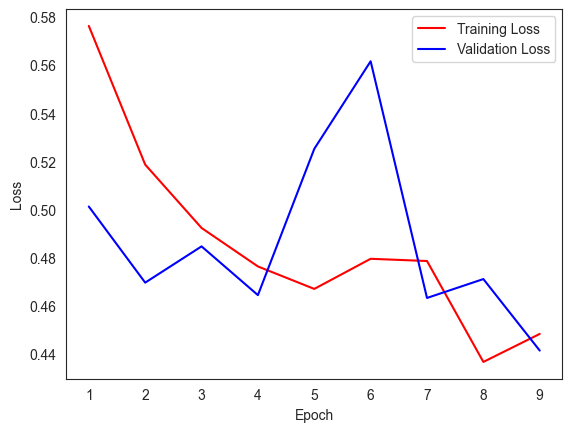

In [57]:
# plot the training loss vs validation loss
plt.plot(
    metrics_df["Epoch"], metrics_df["Training Loss"], label="Training Loss", color="red"
)
plt.plot(
    metrics_df["Epoch"],
    metrics_df["Validation Loss"],
    label="Validation Loss",
    color="blue",
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_labels, correct_preds, _ = evaluate_epoch(model, val_loader, criterion, device)
print(classification_report(all_labels, correct_preds))

Evaluation batches:   0%|          | 0/25 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       571
           1       0.91      0.88      0.90       991

    accuracy                           0.87      1562
   macro avg       0.86      0.86      0.86      1562
weighted avg       0.87      0.87      0.87      1562



Text(50.722222222222214, 0.5, 'Actual')

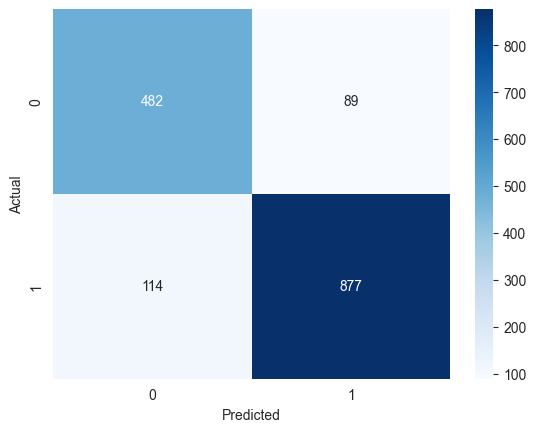

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, correct_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [60]:
# Create a dataset for the test data
test_set = ReviewPuskesmasDataset(test_data, maxlen=512, labeled=False)

# Create a DataLoader for the test data
test_loader = DataLoader(test_set, batch_size=64, num_workers=5)


# Function to predict the labels of the test data
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Prediction batches"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            text_lengths = (input_ids != 0).sum(dim=1).cpu()

            outputs = model(input_ids, text_lengths)

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions


# Predict the labels of the test data
test_predictions = predict(model, test_loader, device)

# Add the predictions to the test data
test_data["predicted_rating"] = test_predictions

test_data.head()

Prediction batches:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_46495/690656802.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_rating'] = test_predictions


,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,predicted_rating
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id,0
18,Anis Suryandari,4,Alhamdullilah pelayanan di Puskesmas Simo bagu...,Puskesmas Simomulyo,alhamdulillah layan puskesmas simo bagus cepat...,id,1
19,Rindi Ariani,2,Puskesmas terlalu dekat dengan depo sampah bau...,Puskesmas Simomulyo,puskesmas depo sampah bau sengat udara panas b...,id,1
22,Della Anugrah Heni,3,berkunjung untuk penerbitan rujukan ke klinik ...,Puskesmas Simomulyo,kunjung terbit rujuk klinik mata akses mudah l...,id,1
27,Wahid Hasan,4,dokternya ramah²....\nAlhamdulillah sdh ada ke...,Puskesmas Simomulyo,dokter ramah alhamdulillah maju,ms,1


In [61]:
# take 5 random samples each from the predicted positive and negative reviews
positive_samples = test_data[test_data["predicted_rating"] == 1].sample(5)
negative_samples = test_data[test_data["predicted_rating"] == 0].sample(5)

# print the positive samples
print("Positive samples:")
for i, row in positive_samples.iterrows():
    print(f'{i}. {row["review_text"]}')

print()

print("Negative samples:")
# print the negative samples
for i, row in negative_samples.iterrows():
    print(f'{i}. {row["review_text"]}')

Positive samples:
1788. Pelayanannya bagus dan dokternya juga ramah
2038. Huaaah nunggu hasil swabnya keburu udah negatif duluan, apalagi kalo pas ditunggu hasilnya positif makin lama lg isolasi mandirinya:(
3855. Ngantarkan istri vaksin booster disini, lokasinya agak masuk kedalam. Namun parkirannya luas. Prosesnya cepat dan tidak lama. Sertifikat vaksin juga langsung masuk ke aplikasi peduli lindungi.
5393. Pelayanan yg baik, bersih n nyaman juga tersedia musholla
4144. Mau tanya selama pandemi covid apakah puskesmas menerima pelayanan KIA

Negative samples:
7257. Dari segi pelayanan sudaah membaik, tapi dr dulu sampai skrg klo minta rujukan susah,alergi dikulit bagian kaki sdh parah smpek susah jln ,disuruh nggu observasi 5hari, ok lah klo emang tdk parah, tp ini dibuat jalan sdh susah. Bagian farmasi g ramah, sering banget ngobrol2 sm makan
8266. Katanya kalo yg daftar online jamnya sama yg tertera di kupon antrian online,ini malah sampe jamnya belum dipanggil",sebenernya dokternya

In [62]:
data_full = pd.concat([train_data, val_data])
data_full.reset_index(drop=True, inplace=True)
data_full.to_csv("predicted-review.csv", index=False)
data_full

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,is_positive
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id,1
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id,0
2,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id,1
3,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id,0
4,Yunia Ardina,1,Saya mau kasih masukan sekaligus protes..\n\nS...,Puskesmas Simomulyo,kasih masuk protes tanggal february jaman prik...,id,0
...,...,...,...,...,...,...,...
9365,Pasca Brawijayanti,5,Pelayanan ok. Ramah. Komunikatif. Hanya saja g...,Puskesmas Jagir,layan ok ramah komunikatif fotokopi puskesmas,id,1
9366,zenda soetjahjo,5,Pelayanan cepat dan sistematis,Puskesmas Medokan Ayu,layan cepat sistematis,id,1
9367,revan rqw,5,Pelayanan bagus,Puskesmas Keputih,layan bagus,id,1
9368,Sandra Berkat,1,Ditelpon tdk ada yg angkat telponnya,Puskesmas Simolawang,telepon angkat telpon,id,0


In [63]:
# show num_row of train, val, and test data
print("train_data_resample.shape:", train_data_resample.shape)
print("val_data.shape:", val_data.shape)
print("test_data.shape:", test_data.shape)

# visualize the seperation of the data ()

train_data_resample.shape: (4568, 7)
val_data.shape: (1562, 7)
test_data.shape: (1218, 7)
